In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps
from sklearn import linear_model
import os
os.chdir('../')

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}

In [2]:
inc_val = 0.0
inc_std = 0.25

D = 4
lb = -5.*np.ones((D,))
ub = 5.*np.ones((D,))

dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]

alphas = ['E', 'P', 'S', 'V']
num_alphas = len(alphas)

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [3]:
def hp_df_to_nf(hp_df):
    nf = NormalizingFlow(
        arch_type=hp_df['arch_type'],
        D=model.D,
        num_stages=int(hp_df['num_stages']),
        num_layers=int(hp_df['num_layers']),
        num_units=int(hp_df['num_units']),
        batch_norm=bool(hp_df['batch_norm']),
        bn_momentum=float(hp_df['bn_momentum']),
        post_affine=bool(hp_df['post_affine']),
        bounds=model._get_bounds(),
        random_seed=int(hp_df['random_seed']),
    )
    return nf

def hp_df_to_aug_lag_hps(hp_df):
    aug_lag_hps = AugLagHPs(
        N=int(hp_df['N']), 
        lr=hp_df['lr'], 
        c0=hp_df['c0'], 
        gamma=hp_df['gamma'], 
        beta=hp_df['beta'],
    )
    return aug_lag_hps

In [4]:
nus = [1., .1, 1., 1.]

opt_dfs = []
hp_df_rows = []
best_ks = []
for j in range(num_alphas):
    alpha = alphas[j]
    name = "V1Circuit_%s" % alpha
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)

    dr = V1_dr_eps(alpha, inc_val)
    model.set_eps(dr)
    mu = np.array([inc_val, inc_std**2])

    hp_df, opt_df = model.get_epi_dfs(mu, prefix='V1Circuit/')
    opt_dfs.append(opt_df)
    best_ind = 0
    maxH = None
    i = 0
    best_k = -1
    for _, hp_df_i in hp_df.iterrows():
        nf = hp_df_to_nf(hp_df_i)
        aug_lag_hps = hp_df_to_aug_lag_hps(hp_df_i)
        k, conv, H = model.get_convergence_epoch(
            mu, 
            nf, 
            aug_lag_hps, 
            prefix='V1Circuit/', 
            nu=nus[j], 
        )
        if (conv and ((maxH is None) or H > maxH)):
            best_ind = i
            maxH = H
            best_k = k
            
        i += 1
        
    best_ks.append(best_k)
    hp_df_rows.append(hp_df.iloc[best_ind])


Checking in V1Circuit/data/V1Circuit_E_dr_mu=0.00E+00_6.25E-02/.
skipping V1Circuit/data/V1Circuit_E_dr_mu=0.00E+00_6.25E-02/temp/hps.p
skipping V1Circuit/data/V1Circuit_E_dr_mu=0.00E+00_6.25E-02/extra/hps.p
skipping V1Circuit/data/V1Circuit_E_dr_mu=0.00E+00_6.25E-02/05_11/hps.p
skipping V1Circuit/data/V1Circuit_E_dr_mu=0.00E+00_6.25E-02/recent/hps.p
Found 1 optimizations.
ckpt_dir
V1Circuit/data/V1Circuit_E_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs9_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
[0. 0.] 0.025
[0. 0.] 0.025
[0. 0.] 0.025
[0. 0.] 0.025
[0.03 0.  ] 0.025
[0.65 0.  ] 0.025
[0.59 0.  ] 0.025
[0.34 0.01] 0.025


KeyboardInterrupt: 

In [9]:
for _, hp_df_i in enumerate(hp_df)

  arch_type  num_stages  num_layers  num_units  batch_norm  bn_momentum  \
3  coupling           3           2         50        True         0.99   

   post_affine  random_seed    N     lr   c0  gamma  beta        H  
3         True            9  500  0.001  1.0   0.25   4.0  5.85755  


In [ ]:
print(best_ks)

In [7]:
q_thetas = []
for i in range(num_alphas):
    alpha = alphas[i]
    hp_df_row = hp_df_rows[i]

    name = "V1Circuit_%s" % alpha
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)

    dr = V1_dr_eps(alpha, inc_val)
    model.set_eps(dr)
    mu = np.array([inc_val, inc_std**2])

    nf = hp_df_to_nf(hp_df_row)
    aug_lag_hps = hp_df_to_aug_lag_hps(hp_df_row)
    q_theta = model.load_epi_dist(
        best_ks[i],
        mu,
        nf,
        aug_lag_hps,
        prefix='V1Circuit/',
    )
    q_thetas.append(q_theta)

ckpt_dir
V1Circuit/data/V1Circuit_E_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs9_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/
ckpt_dir
V1Circuit/data/V1Circuit_P_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs1_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/
ckpt_dir
V1Circuit/data/V1Circuit_S_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs1_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/
ckpt_dir
V1Circuit/data/V1Circuit_V_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs2_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/


In [8]:
z1s = [np.array([[1., 3., 0., 0.],
                 #[0., -3., 0., 0.],
                 [3., 2., 4.2, 0.]]),
       np.array([[0., 1.5, .75, 0.]]),
       np.array([[3., 0., -1., -2.]]),
       np.array([[0., 3., 1., 1.]])
      ]
c_traj = np.array([[0., 0., 0.],
                   [0.7, 0.7, 0.7],
                   [0.4, 0.4, 0.4]])  

E
ckpt_dir
V1Circuit/data/V1Circuit_E_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs9_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/
P
ckpt_dir
V1Circuit/data/V1Circuit_P_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs1_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/
S
ckpt_dir
V1Circuit/data/V1Circuit_S_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs1_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/
V
ckpt_dir
V1Circuit/data/V1Circuit_V_dr_mu=0.00E+00_6.25E-02//D4_C3_L2_U50_bnmom=9.90E-01_PA_rs2_N500_lr1.00E-03_c0=1.00E+00_gamma2.50E-01_beta4.00E+00/


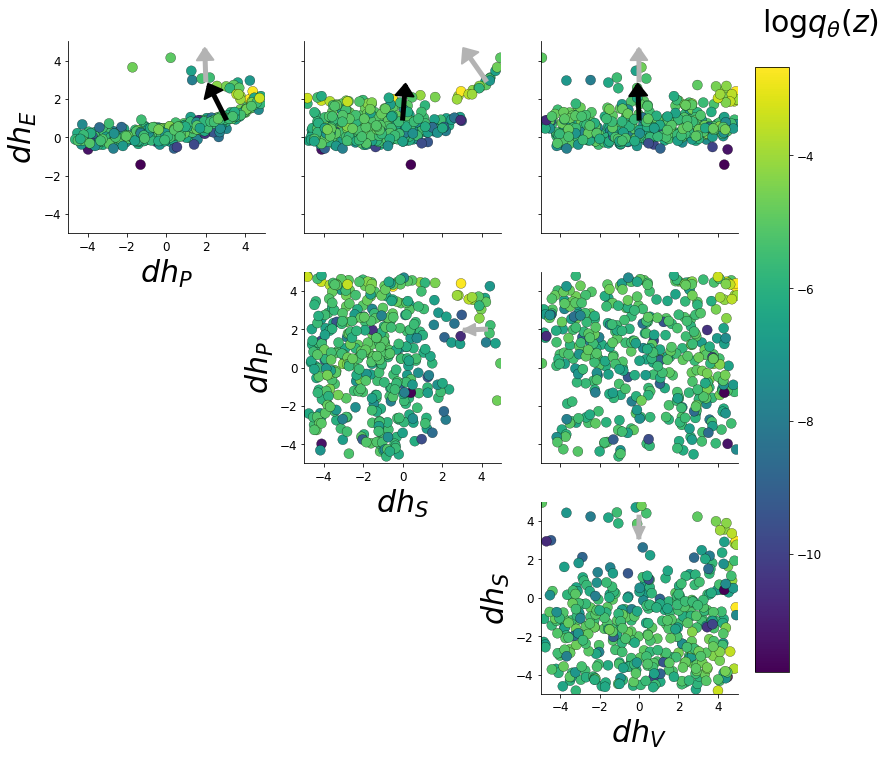

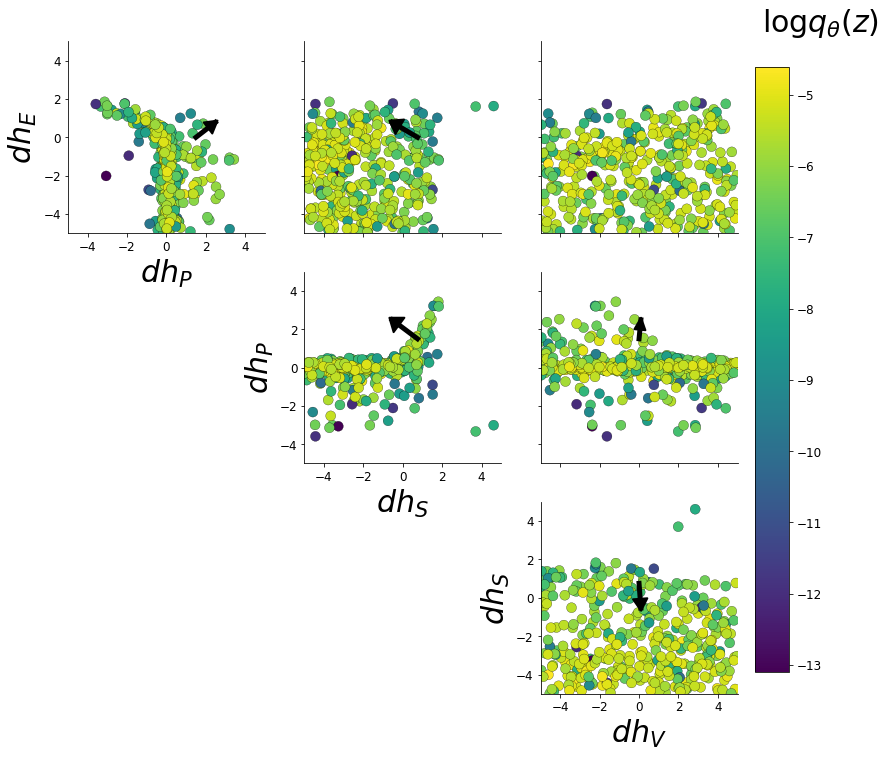

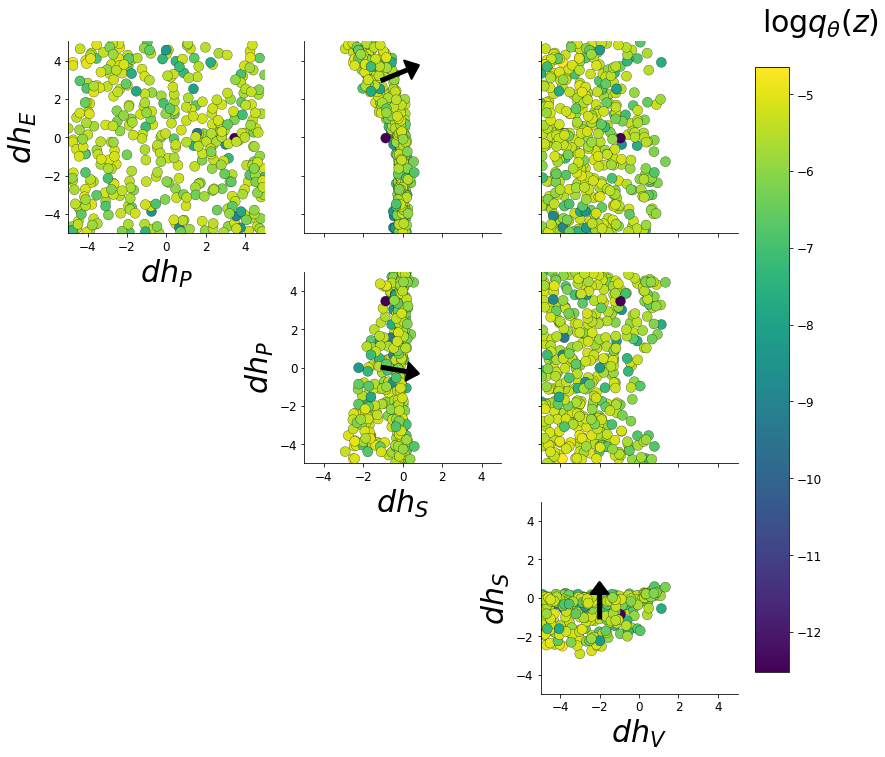

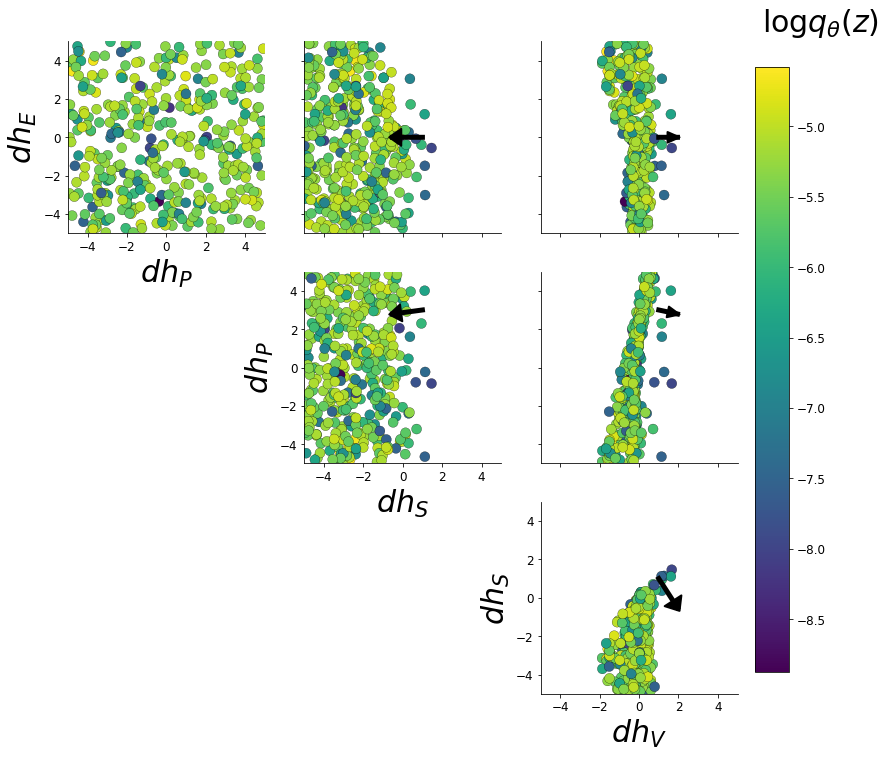

In [9]:
vs = []
T_xs = []
for i in range(num_alphas):
    alpha = alphas[i]
    print(alpha)
    hp_df_row = hp_df_rows[i]

    name = "V1Circuit_%s" % alpha
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)

    dr = V1_dr_eps(alpha, inc_val)
    model.set_eps(dr)
    mu = np.array([inc_val, inc_std**2])

    nf = hp_df_to_nf(hp_df_row)
    aug_lag_hps = hp_df_to_aug_lag_hps(hp_df_row)
    q_theta = model.load_epi_dist(
        best_ks[i],
        mu,
        nf,
        aug_lag_hps,
        prefix='V1Circuit/',
    )
    
    # Get samples
    _N = 10000
    n_plot = 400
    z = q_theta.sample(_N)
    log_prob = q_theta.log_prob(z)
    T_x = model.eps(z).numpy()
    T_xs.append(T_x)
    
    z1 = z1s[i]
    z2 = np.zeros_like(z1)
    num_zs = z1.shape[0]
    _vs = []
    for j in range(num_zs):
        hess = q_theta.hessian(z1[j][None,:])[0]
        d, v = np.linalg.eig(hess)
        eigsort = np.argsort(d)
        v = v[:,eigsort]
        v_sens = v[:,0]
        if v_sens[0] < 0:
            v_sens = -v_sens
        z2[j] = z1[j] + 2*v_sens[None,:]
        _vs.append(v_sens)
    vs.append(_vs)
    

    dims = range(D)
    z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
    fig = pairplot(z[:n_plot], dims, z_labels,
       z1=z1, z2=z2,
       xlims=[-5, 5], ylims=[-5, 5],
       c_label = r'$\log q_\theta(z)$',
       c=log_prob, fontsize=30,
       c_traj=c_traj,
    )

In [11]:
print(vs)
E_vecs = np.array(vs[0])
np.savez('E_sens_vecs.npz', E_vecs=E_vecs)

[[array([ 0.89409703, -0.4408315 ,  0.07119917, -0.03447896], dtype=float32), array([ 0.8254859 , -0.02630755, -0.5637853 , -0.00520552], dtype=float32)], [array([ 0.43428844,  0.5474568 , -0.7134999 ,  0.05101431], dtype=float32)], [array([ 0.37953287, -0.15877134,  0.9114465 , -0.00341932], dtype=float32)], [array([ 1.4671736e-04, -1.1618109e-01, -8.4146154e-01,  5.2767837e-01],
      dtype=float32)]]


In [50]:
def calc_sensitivity(delta, d):
    abs_delta = np.abs(delta)
    m, b, r, p, stderr = scipy.stats.linregress(abs_delta, d)
    return m, p

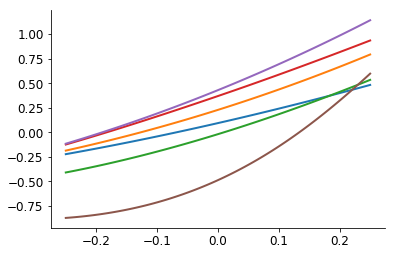

In [56]:
K = 101
max_delta = 0.25
delta = np.linspace(-max_delta, max_delta, K)
num_rand = 1000

ms = []
rand_ms = []
for i in range(num_alphas):
    alpha = alphas[i]
    
    name = "V1Circuit_%s" % alpha
    dh = Parameter("dh", D, lb=lb, ub=ub)
    parameters = [dh]
    model = Model(name, parameters)

    dr = V1_dr_eps(alpha, inc_val)
    model.set_eps(dr)
    mu = np.array([inc_val, inc_std**2])
    
    z1 = z1s[i]
    num_zs = z1.shape[0]
    _ms = []
    _rand_ms = []
    for j in range(num_zs):
        z0 = z1[j][None,:]
        v = vs[i][j][None,:]
        z_perturb = z0 + delta[:,None]*v
        T_perturb = model.eps(z_perturb)
        m, p = calc_sensitivity(delta, np.square(T_perturb[:,0]))
        _ms.append(m)
        
        rand_ms_j = []
        z_perturb = []
        for k in range(num_rand):
            v = np.random.normal(0., 1., (1,model.D))
            v = v / np.linalg.norm(v)
            z_perturb.append(z0+delta[:,None]*v)
        z_perturb = np.concatenate(z_perturb, axis=0)
        T_perturb = model.eps(z_perturb)
        for k in range(num_rand):
            start_ind = k*K
            end_ind = (k+1)*K
            m, p = calc_sensitivity(delta, np.square(T_perturb[start_ind:end_ind,0]))
            rand_ms_j.append(m)
        _rand_ms.append(rand_ms_j)
    ms.append(_ms)
    rand_ms.append(np.array(_rand_ms))    

In [64]:
z0 = z1s[0][0][None,:]
v = vs[0][2][None,:]
z_perturb = z0 + delta[:,None]*v
T_perturb = model.eps(z_perturb)
m20, p = calc_sensitivity(delta, np.square(T_perturb[:,0]))

z0 = z1s[0][2][None,:]
v = vs[0][0][None,:]
z_perturb = z0 + delta[:,None]*v
T_perturb = model.eps(z_perturb)
m02, p = calc_sensitivity(delta, np.square(T_perturb[:,0]))

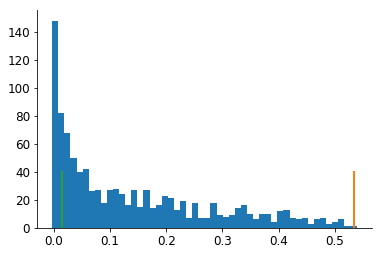

In [65]:
plt.figure()
plt.hist(rand_ms[0][0], 50)
plt.plot([ms[0][0], ms[0][0]], [0, 40])
plt.plot([m20, m20], [0, 40])
plt.show()

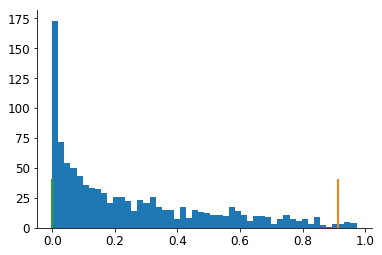

In [67]:
plt.figure()
plt.hist(rand_ms[0][2], 50)
plt.plot([ms[0][2], ms[0][2]], [0, 40])
plt.plot([m02, m02], [0, 40])
plt.show()

0.999


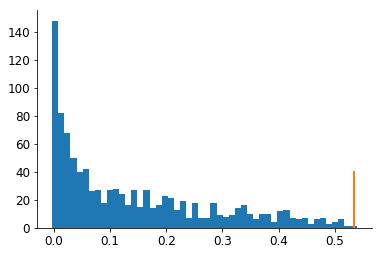

0.997


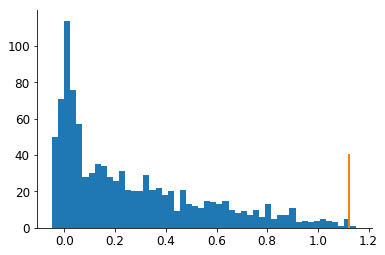

0.988


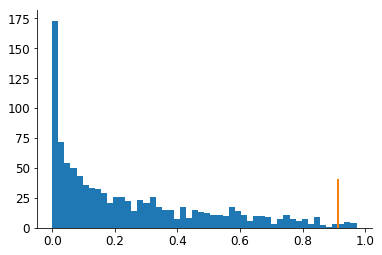

0.991


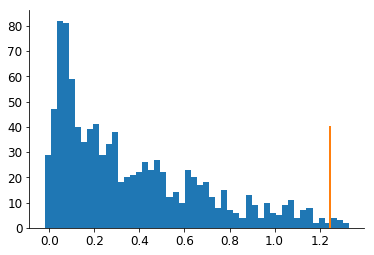

1.0


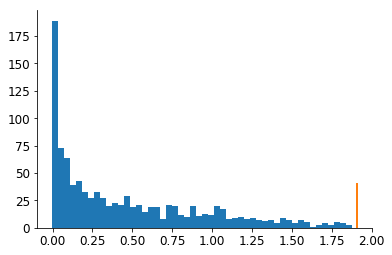

0.993


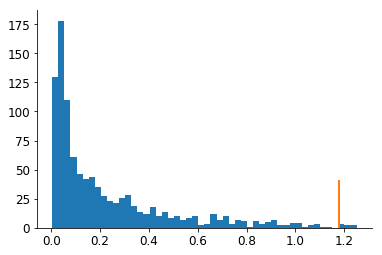

In [57]:
for i in range(num_alphas):
    z1 = z1s[i]
    num_zs = z1.shape[0]
    for j in range(num_zs):
        m_ij = ms[i][j]
        print(np.sum(m_ij > rand_ms[i][j]) / num_rand)
        plt.figure()
        plt.hist(rand_ms[i][j], 50)
        plt.plot([m_ij, m_ij], [0, 40])
        plt.show()

(10000, 2)
0.05885881


IndexError: list index out of range

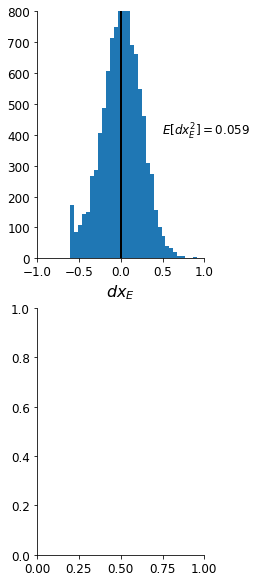

In [62]:
print(T_xs[0].shape)
max_y = 800
fig, axs = plt.subplots(num_alphas, 1, figsize=(3, 10))
for i in range(num_alphas):
    ax = axs[i]
    alpha = alphas[i]
    dxi = T_xs[i][:,0]
    mean_dxi = np.mean(dxi)
    var_dxi = np.mean(dxi**2)
    print(var_dxi)
    ax.hist(dxi, bins=50, density=False)
    ax.plot([mean_dxi, mean_dxi], [0, max_y], 'k-')
    ax.plot([0, 0], [0, max_y], 'k--')
    ax.set_xlabel(r'$dx_%s$' % alpha)
    ax.set_xlim([-1, 1])
    ax.set_ylim([0, max_y])
    ax.text(0.5, 400, r'$E[dx_%s^2] = %.3f$' % (alpha, var_dxi), fontsize=12)
plt.tight_layout()
plt.show()

### Hess path

In [6]:
"""K = 10
zs = np.zeros((num_alphas, num_alphas, K+1))
beta = 0.5

signs = [-1,1,-1,-1]
for k in range(K):
    for i in range(num_alphas):
        z_ik = zs[i,:,k][None,:]
        hess = np.zeros((num_alphas, num_alphas))
        for j in range(num_alphas):
            hess_j = q_thetas[j].hessian(z_ik)[0]
            if i==j:
                hess += hess_j
            else:
                hess -= hess_j



        w, v = np.linalg.eig(hess)
        eigsort = np.argsort(w)
        w = w[eigsort]
        v = v[:, eigsort]
        v1 = v[:,0]
        if signs[i]*v1[i] < 0.:
            v1 = -v1
        zs[i,:,k+1] = z_ik + beta*v1
        
"""

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### EPI grad path

In [22]:
K = 50
zs_EPI = np.zeros((num_alphas, num_alphas, K+1))
beta = 0.1

for k in range(K):
    for i in range(num_alphas):
        z_ik = zs_EPI[i,:,k][None,:]
        grad = np.zeros((num_alphas,))
        for j in range(num_alphas):
            grad_j = q_thetas[j].gradient(z_ik)[0]
            grad_j = grad_j / np.linalg.norm(grad_j)
            if i==j:
                grad -= grad_j
            else:
                grad += grad_j
        grad = grad/np.linalg.norm(grad)
        zs_EPI[i,:,k+1] = z_ik + beta*grad
        

### No EPI path


### Random

In [31]:
name = "V1Circuit"
dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]
model = Model(name, parameters)

dr = V1_all_dr_eps(inc_val)
model.set_eps(dr)


#beta = 0.5
z0 = np.random.normal(0., 0.001, (1,4)).astype(np.float32)
zs_model = np.zeros((num_alphas, num_alphas, K+1), dtype=np.float32)
for i in range(num_alphas):
    zs_model[i,:,0] = z0[0]
    
for i in range(num_alphas):
    for k in range(K):
        z_ik = zs_model[i,:,k]
        z = tf.Variable(initial_value=z_ik[None,:], trainable=True)
        with tf.GradientTape() as tape:
            dx = model.eps(z)[0]
            L = 0.
            for j in range(num_alphas):
                if i == j:
                    L += dx[j]**2
                else:
                    L -= dx[j]**2
            grad = tape.gradient(L, z)[0].numpy()
            v = grad / np.linalg.norm(grad)
            zs_model[i,:,k+1] = z_ik + beta*v
            


In [97]:
#np.savez('hess_paths.npz', zs=zs)

In [43]:
import matplotlib 
z1s = zs_model[:,:,:K]
z2s = zs_model[:,:,1:]

z1s = np.reshape(np.transpose(z1s, [1,0,2]), (num_alphas, num_alphas*K))
z2s = np.reshape(np.transpose(z2s, [1,0,2]), (num_alphas, num_alphas*K))

c_traj = np.ones((num_alphas*K,3))
for i in range(num_alphas):
    for k in range(K):
        c_traj[i*K+k] = matplotlib.colors.to_rgb(colors[i])

### Start control comparisons here

In [25]:
name = "V1Circuit"
dh = Parameter("dh", D, lb=lb, ub=ub)
parameters = [dh]
model = Model(name, parameters)

dr = V1_all_dr_eps(inc_val)
model.set_eps(dr)

#npzfile = np.load("hess_paths.npz")
#zs = npzfile['zs']
K = zs_EPI.shape[2]-1


### Generate random data

In [26]:
num_rand = 50
zs_rand = np.zeros((num_alphas, num_alphas, num_rand, K+1))

vecs = np.random.normal(0., 1., (num_alphas, num_alphas, num_rand, K+1))
vecs = vecs / np.linalg.norm(vecs, axis=3)[:,:,:,None]

for i in range(num_alphas):
    for n in range(num_rand):
        for k in range(K):
            zk = zs_rand[i,:,n,k]
            v = vecs[i,:,n,k]
            #if signs[i]*v[i] < 0.:
            #    v = -v
            zs_rand[i,:,n,k+1] = zk + beta*v

In [40]:
diffs_alpha = []
diffs_rest = []

diffs_model_alpha = []
diffs_model_rest = []

diffs_alpha_mean = []
diffs_alpha_var = []
diffs_rest_mean = []
diffs_rest_var = []

dxs = []
dxs_model = []
for i in range(num_alphas):
    alpha = alphas[i]
    
    # Grad path responses
    dx = model.eps(zs_EPI[i].T)
    dxs.append(dx)
    _diffs_rest = np.zeros((K+1,))
    for j in range(num_alphas):
        if (i==j):
            diffs_alpha.append(np.square(dx[:,j]))
        else:
            _diffs_rest += np.square(dx[:,j])
    diffs_rest.append(_diffs_rest)
    
    # Grad path responses
    dx = model.eps(zs_model[i].T)
    dxs_model.append(dx)
    _diffs_model_rest = np.zeros((K+1,))
    for j in range(num_alphas):
        if (i==j):
            diffs_model_alpha.append(np.square(dx[:,j]))
        else:
            _diffs_model_rest += np.square(dx[:,j])
    diffs_model_rest.append(_diffs_model_rest)
    
    
    # Random responses.
    zs_rand_i = np.reshape(zs_rand[i], (num_alphas, num_rand*(K+1)))
    dx = model.eps(zs_rand_i.T)
    dx = np.reshape(dx, (num_rand, K+1, dx.shape[1]))[:,:,:4]
    
    _diffs_rest_mean = np.zeros((K+1,))
    _diffs_rest = np.zeros((num_rand, K+1,))
    for j in range(num_alphas):
        if i==j:
            diffs_alpha_mean.append(np.mean(np.square(dx[:,:,j]), axis=0))
            diffs_alpha_var.append(np.std(np.square(dx[:,:,j]), axis=0)/np.sqrt(num_rand))
        else:
            _diffs_rest_mean += np.mean(np.square(dx[:,:,j]), axis=0)
            _diffs_rest += np.square(dx[:,:,j])
    diffs_rest_mean.append(_diffs_rest_mean)
    diffs_rest_var.append(np.std(_diffs_rest, axis=0) / np.sqrt(num_rand))
    
    
diffs_alpha = np.array(diffs_alpha)
diffs_rest = np.array(diffs_rest)

diffs_alpha_mean = np.array(diffs_alpha_mean)
diffs_alpha_var = np.array(diffs_alpha_var)
diffs_rest_mean = np.array(diffs_rest_mean)
diffs_rest_var = np.array(diffs_rest_var)


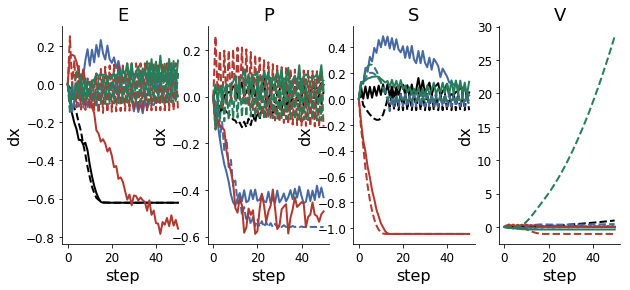

In [41]:
fig, axs = plt.subplots(1,4,figsize=(10,4))
for i in range(num_alphas):
    ax = axs[i]
    alpha = alphas[i]
    
    for j in range(num_alphas):
        ax.plot(dxs[i][:,j], c=colors[j])
        ax.plot(dxs_model[i][:,j], '--', c=colors[j])
    ax.set_xlabel('step')
    ax.set_ylabel('dx')
    ax.set_title(alpha)

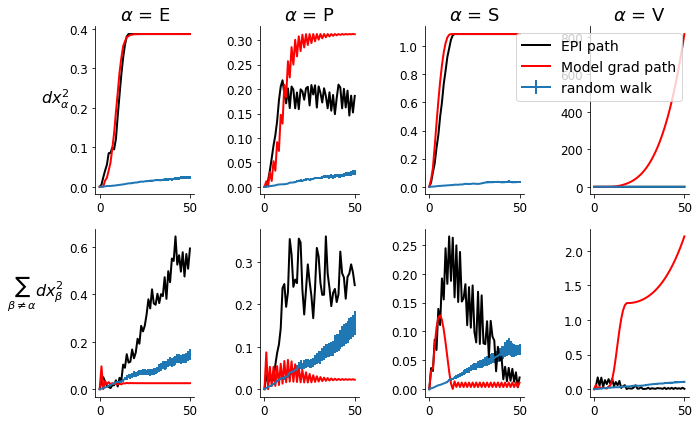

In [42]:
fig, axs = plt.subplots(2,4,figsize=(10,6))
for i in range(num_alphas):
    alpha = alphas[i]
    axs[0,i].plot(diffs_alpha[i], 'k-')
    axs[0,i].plot(diffs_model_alpha[i], 'r-')
    axs[0,i].errorbar(np.arange(K+1), diffs_alpha_mean[i], diffs_alpha_var[i])
    axs[1,i].plot(diffs_rest[i], 'k-')
    axs[1,i].plot(diffs_model_rest[i], 'r-')
    axs[1,i].errorbar(np.arange(K+1), diffs_rest_mean[i], diffs_rest_var[i])
    axs[0,i].set_title(r'$\alpha$ = %s' % alpha)
    
axs[0,0].set_ylabel(r'$dx_\alpha^2$', rotation=0)
axs[0,0].yaxis.set_label_coords(-0.4,0.5)
axs[1,0].set_ylabel(r'$\sum_{\beta \neq \alpha} dx_{\beta}^2$', rotation=0)
axs[1,0].yaxis.set_label_coords(-0.6,0.5)

axs[0,-1].legend(['EPI path', 'Model grad path', 'random walk'])
plt.tight_layout()
plt.show()